In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1

import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.fig_utils import full_dist_to_print, dataset_to_print, dist_to_color, dist_to_print, full_dist_to_color
from utils.io_utils import load_multiple_res, dist_kwargs_to_str
from utils.pd_utils import compute_outlier_scores, filter_dgms
import os
import numpy as np
import copy

In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# l_p distances on the 1D datasets

In [4]:
datasets = ["toy_circle", "inter_circles", "eyeglasses"]

embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

# different datas
sigmas_per_dataset = {}
for dataset in datasets:
    if dataset == "eyeglasses":
        sigmas_per_dataset[dataset] = sigmas[:13]
    else:
        sigmas_per_dataset[dataset] = sigmas

In [5]:
distances = {
    "euclidean": [{}],
    "minkowski": [{"p": p} for p in [3, 5, 7, np.inf]],
}

distances_by_dataset = {dataset: copy.deepcopy(distances) for dataset in datasets}

# only load the best eff res settings for each dataset
k_by_dataset = {"toy_circle": 100,
                "eyeglasses": 15,
                "inter_circles": 15,
                }

for dataset in k_by_dataset:
    distances_by_dataset[dataset]["eff_res"] = {"corrected": True, "weighted": False, "k": k_by_dataset[dataset], "disconnect": True}

In [6]:
#load data
all_res = {1: {}}
for dataset in datasets:
    all_res[1][dataset] = load_multiple_res(datasets=dataset,
                                         distances=distances_by_dataset[dataset],
                                         root_path=get_path("data"),
                                         n=n,
                                         seeds=seeds,
                                         sigmas=sigmas_per_dataset[dataset],
                                         embd_dims=embd_dim,
                                         n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0
Done with toy_circle 50 minkowski_p_3 n_outliers=0
Done with toy_circle 50 minkowski_p_5 n_outliers=0
Done with toy_circle 50 minkowski_p_7 n_outliers=0
Done with toy_circle 50 minkowski_p_inf n_outliers=0
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0
Done with inter_circles 50 euclidean n_outliers=0
Done with inter_circles 50 minkowski_p_3 n_outliers=0
Done with inter_circles 50 minkowski_p_5 n_outliers=0
Done with inter_circles 50 minkowski_p_7 n_outliers=0
Done with inter_circles 50 minkowski_p_inf n_outliers=0
Done with inter_circles 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True n_outliers=0
Done with eyeglasses 50 euclidean n_outliers=0
Done with eyeglasses 50 minkowski_p_3 n_outliers=0
Done with eyeglasses 50 minkowski_p_5 n_outliers=0
Done with eyeglasses 50 minkowski_p_7 n_outliers=0
Done with eyeglasses 50 minkowski_p_inf n_outliers=0
Done with eyeglasses 50 eff_re

In [7]:
# thresholding
dob = 1.25
all_res = filter_dgms(dgms=all_res, dob=dob, dim=1, binary=True)
all_res = filter_dgms(dgms=all_res, dob=dob, dim=2, binary=True)

In [8]:
all_res[2] = None

In [9]:
# compute the detection score
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "inter_circles": 2,
        "eyeglasses": 1,
    },
    2: {
    }
}

outlier_scores_1d = {dataset: compute_outlier_scores(all_res[1][dataset], 
                                                     n_features=cycles_per_dataset[1][dataset],
                                                     dim=1)
                     for dataset in cycles_per_dataset[1]}
outlier_scores_2d = {dataset: compute_outlier_scores(all_res[2][dataset],
                                                     n_features=cycles_per_dataset[2][dataset],
                                                     dim=2)
                     for dataset in cycles_per_dataset[2]}

outlier_scores = {
    1: outlier_scores_1d,
    2: outlier_scores_2d
}

In [10]:
# create new colors for the L_p distances
import glasbey

colors = glasbey.create_block_palette([4, 4])
print(colors)
for i, p in enumerate([3, 5, 7, "inf"]):
    full_dist_to_color[f"minkowski_p_{p}"] = colors[i]

['#003f70', '#006dc4', '#2e9cff', '#c5cbff', '#4d001b', '#9f0f1e', '#de3b29', '#ff9640']


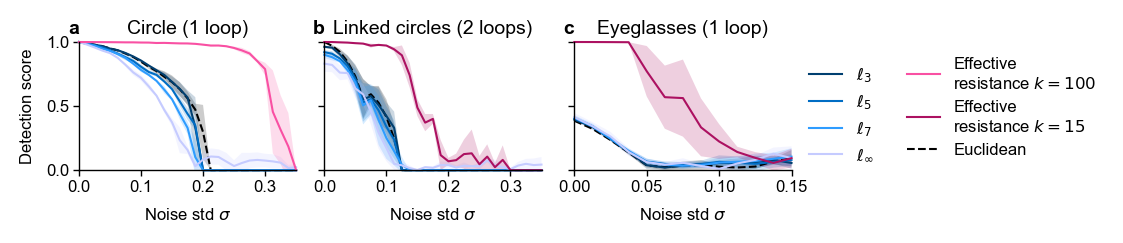

In [11]:
# plot figure
npanels = len(cycles_per_dataset[1]) + len(cycles_per_dataset[2]) +1
nrows = 2
ncols =  int(np.ceil(npanels /2))

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(5.5, 1.1))

y_label="Detection score"
letters = "abcdefgh"
shift = 0

for i in range(npanels-1):
    feature_dim = 1 if i < len(cycles_per_dataset[1]) else 2
    if i == 5: 
        shift = 1
        continue

    dataset = list(cycles_per_dataset[feature_dim].keys())[i]
    
    for dist in all_res[feature_dim][dataset]:
        for full_dist in all_res[feature_dim][dataset][dist]:
            mean = outlier_scores[feature_dim][dataset][dist][full_dist].mean(1)
            std = outlier_scores[feature_dim][dataset][dist][full_dist].std(1)
            
            if dist != "euclidean":
                ax[i].plot(sigmas_per_dataset[dataset], 
                           mean,
                            label=full_dist_to_print[full_dist],
                            color=full_dist_to_color[full_dist],
                           clip_on=False)
                ax[i].fill_between(
                    sigmas_per_dataset[dataset],
                    mean - std,
                    mean + std,
                    alpha=0.2,
                    color=full_dist_to_color[full_dist],
                    edgecolor=None,
                )
                
            else:
                ax[i].plot(sigmas_per_dataset[dataset], 
                              mean,
                              label=full_dist_to_print[full_dist],
                              color=full_dist_to_color[full_dist],
                              clip_on=False,
                              linestyle="dashed")
                ax[i].fill_between(
                    sigmas_per_dataset[dataset],
                    mean - std,
                    mean + std,
                    alpha=0.2,
                    color=full_dist_to_color[full_dist],
                    edgecolor=None,
                )       
        
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, sigmas_per_dataset[dataset].max())
    ax[i].set_xlabel("Noise std $\sigma$")
    if i==0:
        ax[i].set_ylabel(y_label)
        
    if i > 0:
        ax[i].set_yticklabels([])
        
    if i == 0 or i==2:
        ax[i].set_title(dataset_to_print[dataset] + f" (1 loop)")
    elif i == 1:
        ax[i].set_title(dataset_to_print[dataset] + f" (2 loops)")
    elif i==3 or i==4:
        ax[i].set_title(dataset_to_print[dataset] + f" (2 loop)")
    elif i==6 or i==7:
        ax[i].set_title(dataset_to_print[dataset] + f" (1 void)")  
    
    ax[i].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)

handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = ax[1].get_legend_handles_labels()
handles = handles[1:] + [handles2[-1]]+ [handles[0]]
labels = labels[1:] + [labels2[-1]]+ [labels[0]]
ax[2].legend(loc=(1.05, 0.0),
                handles=handles,
             frameon=False,
             ncols=2
      )
fig.savefig(os.path.join(fig_path, "fig_datasets_Lp.pdf"))